<a href="https://colab.research.google.com/github/PhmHiu/Car-Segmentation/blob/main/Carvana_Image_Masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
zip_path = 'drive/MyDrive/DATA/Carvana_masking/train.zip'
!cp "{zip_path}" .
!unzip -q train.zip
!rm train.zip

zip_path = 'drive/MyDrive/DATA/Carvana_masking/train_masks.zip'
!cp "{zip_path}" .
!unzip -q train_masks.zip
!rm train_masks.zip

# Khai bao thu vien

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from PIL import Image
from keras.preprocessing import image
import cv2
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from keras import Model
from keras.losses import SparseCategoricalCrossentropy
from keras.callbacks import ModelCheckpoint
import random
import keras

# Load du lieu

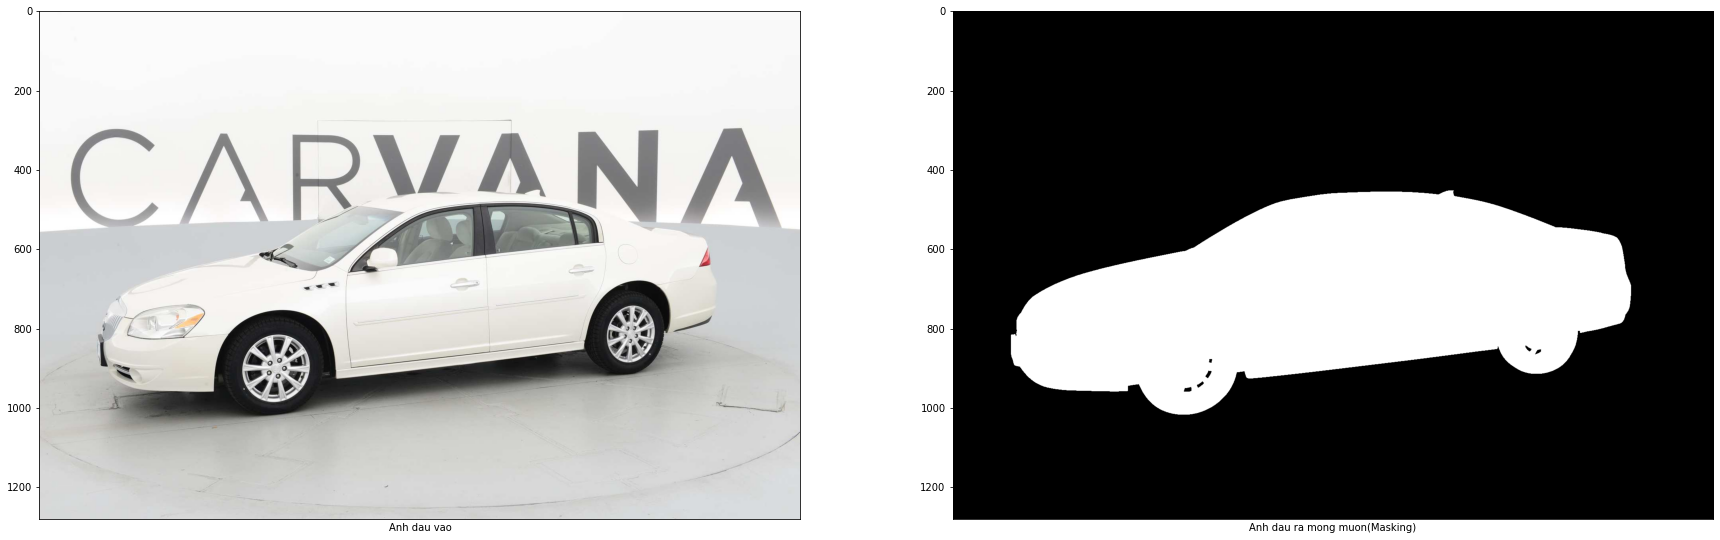

Kich thuoc cua anh dau vao:  (1280, 1918, 3)
Kich thuoc cua mask:  (1280, 1918, 1)
Tong so anh dung de train la:  5088
(4070, 128, 128, 3) (4070, 128, 128, 1) (1018, 128, 128, 3) (1018, 128, 128, 1)


In [ ]:
fig = plt.figure(figsize=(30, 15))
img = cv2.imread(r'/content/train/d46244bc42ed_04.jpg') #Link anh
mask = Image.open(r'/content/train_masks/d46244bc42ed_04_mask.gif') #Link mask

#In 1 anh dau vao de test
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xlabel('Anh dau vao')
plt.xticks([])
#Mask tuong ung
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.xlabel('Anh dau ra mong muon(Masking)')
plt.xticks([])
plt.show()

print('Kich thuoc cua anh dau vao: ',img.shape)
print('Kich thuoc cua mask: ', image.img_to_array(mask).shape)

#Ham nhan vao anh va mask, xu ly anh dua ve 0->1, resize ca 2 ve 128x128 de cho vao model
def preprocess_image(img,mask,train=True):
    input_img = cv2.resize(img, (128, 128))/255.0
    input_mask = cv2.resize(mask, (128, 128))
    return input_img, input_mask

#Ham load anh tu folder va tra ve anh va mask
def load_imgs(name):
    input_img = cv2.imread('/content/train/'+name+'.jpg')
    input_mask = image.img_to_array(Image.open('/content/train_masks/'+name+'_mask.gif'))
    input_img, input_mask = preprocess_image(input_img, input_mask)
    return input_img, input_mask


x_data = []
y_data = []

#Lay het link anh trong folder va cho vao trong 1 list
imgs_path = glob.glob('/content/train/*')

#Shuffle link len
random.shuffle(imgs_path)
a = len(imgs_path)
print('Tong so anh dung de train la: ', a)

for i in range(a):
    input_img, input_mask = load_imgs(imgs_path[i][15:-4])
    x_data.append(input_img)
    y_data.append(input_mask)

x_d = np.array(x_data)
y_d = np.array(y_data)

#80% de train va 20% de validation
train_data = int((x_d.shape[0]*0.80))
x_train = x_d[:train_data]
y_train = y_d[:train_data]
x_val = x_d[train_data:]
y_val = y_d[train_data:]
y_train=y_train[..., np.newaxis]
y_val=y_val[..., np.newaxis]
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

# Model

In [ ]:
inputs = Input((128, 128, 3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
upsamp6 = UpSampling2D(size=(2,2))(drop5)
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upsamp6)
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
upsamp7 = UpSampling2D(size=(2,2))(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upsamp7)
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(merge7)
upsamp8 = UpSampling2D(size=(2, 2))(conv7)
up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer = 'he_normal')(upsamp8)
merge8 = concatenate([conv2, up8], axis=3)
conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer = 'he_normal')(merge8)
upsamp9 = UpSampling2D(size=(2, 2))(conv8)
up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(upsamp9)
merge9 = concatenate([conv1, up9], axis = 3)
conv9 = Conv2D(64, 3, activation='relu', padding = 'same', kernel_initializer='he_normal')(merge9)
output = Conv2D(2, 1, activation='softmax', padding='same', kernel_initializer='he_normal')(conv9)

model = Model(inputs, output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Train model

In [ ]:
model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(), metrics=['accuracy'])

model_history = model.fit(x_train, y_train, epochs=10, validation_data=(x_val, y_val), verbose=1, batch_size=64, callbacks=[ModelCheckpoint('Carvana.h5', save_best_only=True)])

Epoch 1/10
64/64 [==============================] - 70s 884ms/step - loss: 3.1124 - accuracy: 0.7819 - val_loss: 0.1283 - val_accuracy: 0.9450
Epoch 2/10
64/64 [==============================] - 52s 809ms/step - loss: 0.0881 - accuracy: 0.9634 - val_loss: 0.0438 - val_accuracy: 0.9821
Epoch 3/10
64/64 [==============================] - 52s 810ms/step - loss: 0.0434 - accuracy: 0.9816 - val_loss: 0.0293 - val_accuracy: 0.9875
Epoch 4/10
64/64 [==============================] - 52s 814ms/step - loss: 0.0271 - accuracy: 0.9882 - val_loss: 0.0226 - val_accuracy: 0.9901
Epoch 5/10
64/64 [==============================] - 52s 813ms/step - loss: 0.0218 - accuracy: 0.9903 - val_loss: 0.0202 - val_accuracy: 0.9909
Epoch 6/10
64/64 [==============================] - 52s 815ms/step - loss: 0.0190 - accuracy: 0.9915 - val_loss: 0.0180 - val_accuracy: 0.9918
Epoch 7/10
64/64 [==============================] - 52s 818ms/step - loss: 0.0171 - accuracy: 0.9922 - val_loss: 0.0164 - val_accuracy: 0.9925

# Chay thu ket qua

In [ ]:
i=13

test_imgs_path = glob.glob('/content/drive/MyDrive/DATA/Carvana_masking/test/*')#Link anh test
random.shuffle(test_imgs_path)
b = len(test_imgs_path)
print(b)

test_img = cv2.imread(test_imgs_path[i])
test_img = cv2.resize(test_img, (128, 128))
x_test = test_img/255.0
x_test = np.reshape(x_test, (1, 128, 128, 3))#Dua ve size phu hop voi model
print(x_test.shape)

1000
(1, 128, 128, 3)


Shape cua dau ra du doan tu model:  (1, 128, 128, 2)
Shape cua dau ra sau khi reshape:  (128, 128, 1)


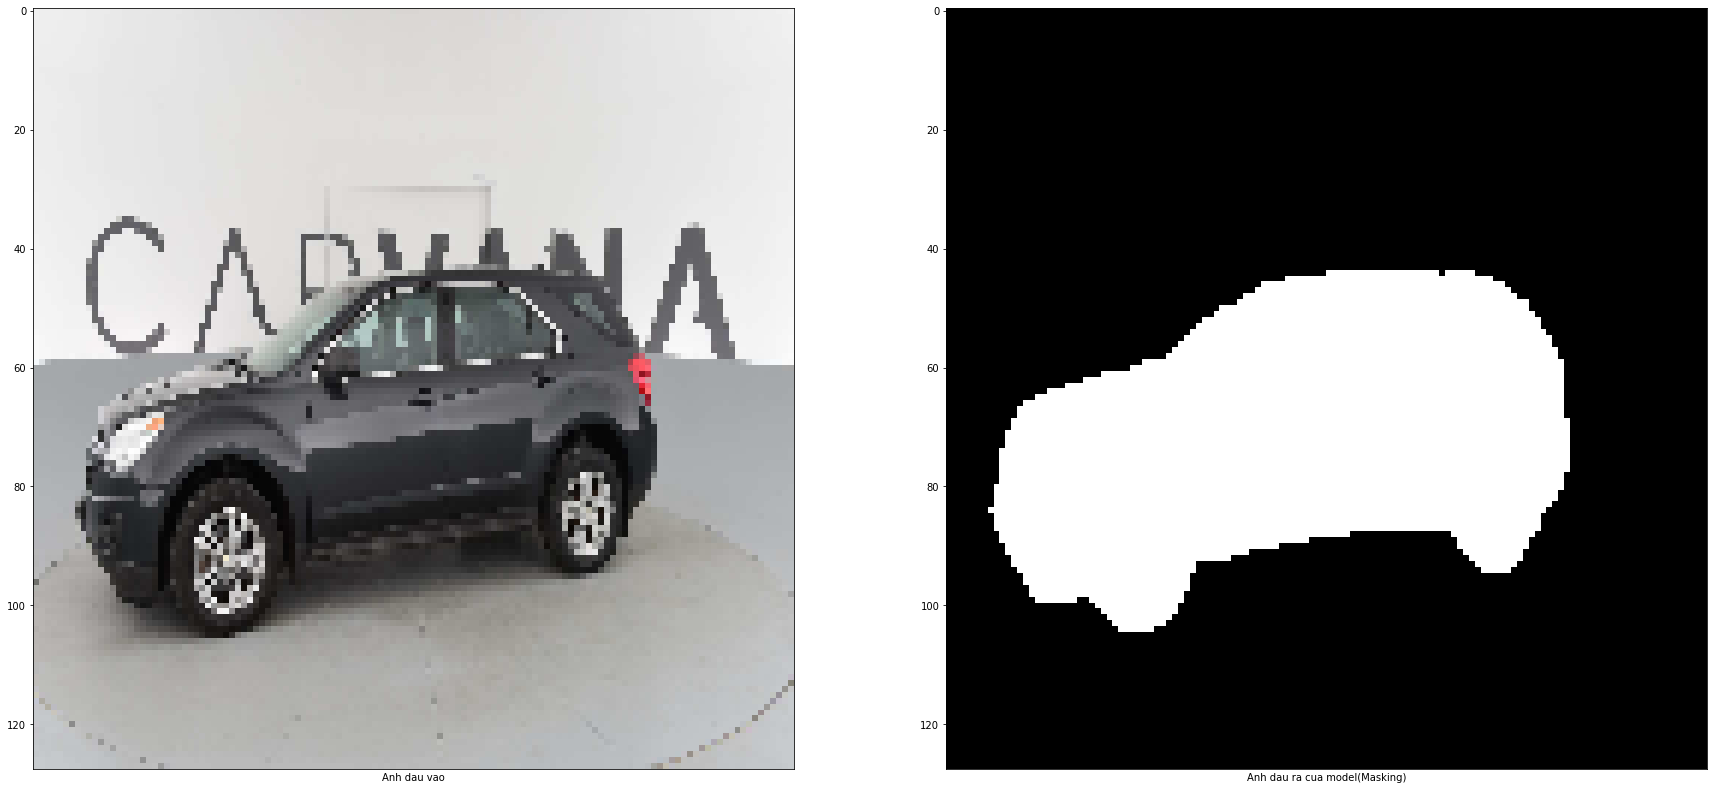

In [ ]:
pred_mask = model.predict(x_test)
print('Shape cua dau ra du doan tu model: ', pred_mask.shape)
y_pred=np.argmax(pred_mask[0], -1)
y_pred=np.reshape(y_pred, (128, 128, 1))
print('Shape cua dau ra sau khi reshape: ', y_pred.shape)

fig=plt.figure(figsize=(30, 15))
img=test_img
pred_mask=image.array_to_img(y_pred)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xlabel('Anh dau vao')
plt.xticks([])
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.xlabel('Anh dau ra cua model(Masking)')
plt.xticks([])
plt.show()

(1, 128, 128, 3)
Shape cua dau ra du doan tu model:  (1, 128, 128, 2)
Shape cua dau ra sau khi reshape:  (128, 128, 1)


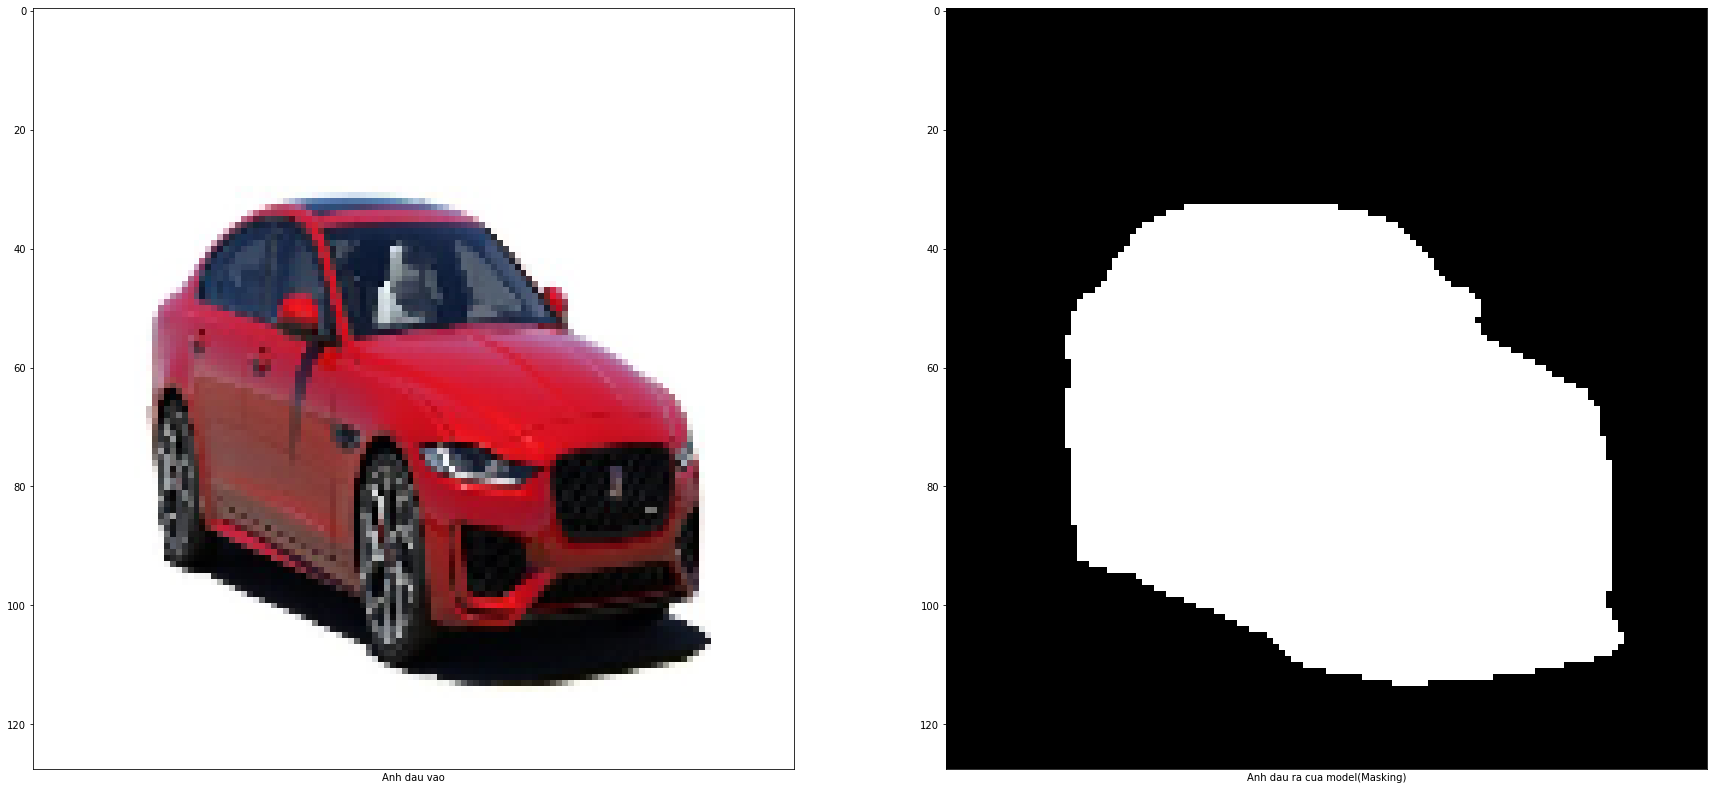

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/car.jpeg')
test_img = cv2.resize(test_img, (128, 128))
x_test = test_img/255.0
x_test = np.reshape(x_test, (1, 128, 128, 3))#Dua ve size phu hop voi model
print(x_test.shape)
pred_mask = model.predict(x_test)
print('Shape cua dau ra du doan tu model: ', pred_mask.shape)
y_pred=np.argmax(pred_mask[0], -1)
y_pred=np.reshape(y_pred, (128, 128, 1))
print('Shape cua dau ra sau khi reshape: ', y_pred.shape)
fig=plt.figure(figsize=(30, 15))
img=test_img
pred_mask=image.array_to_img(y_pred)

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.xlabel('Anh dau vao')
plt.xticks([])
plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='gray')
plt.xlabel('Anh dau ra cua model(Masking)')
plt.xticks([])
plt.show()